## Моделирование оттока клиентов банка

### Оглавление
1. Знакомство с данными.
- импорт библиотек.
2. Подготовка данных.
3. Исследование баланса классов и первое обучение модели (без учета дисбаланса).
4. Улучшение качества модели (с учетом дисбаланса классов). Выбор лучшей модели.
5. Финальное тестирование.
6. Общий вывод.

### 1.Знакомство с данными

<a id='section1.1'></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import  shuffle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('F:/DS/Projects/Churn.csv', sep = None)

In [4]:
df.shape

(10000, 14)

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Проверим, есть ли дубликаты в идентификаторе клиента.

In [7]:
df['CustomerId'].duplicated().sum()

0

Создадим сводную табличку по количеству, доле пропусков в признаках с указанием типа данных.

In [8]:
total = df.isnull().sum()
percent = ((df.isnull().sum()/df.isnull().count())*100).round(2)
missing = pd.concat([total, percent], axis = 1, keys = ['Total_missing_values', 'Percent%'])
missing['dtype'] = df.dtypes
missing

,Total_missing_values,Percent%,dtype
RowNumber,0,0.00,int64
CustomerId,0,0.00,int64
Surname,0,0.00,object
CreditScore,0,0.00,int64
Geography,0,0.00,object
Gender,0,0.00,object
Age,0,0.00,int64
Tenure,909,9.09,float64
Balance,0,0.00,float64
NumOfProducts,0,0.00,int64


#### Итог по разделу

Данных немало, можно сделать хорошее исследование (10000 строк).\
Данные почти не содержат пропусков (исключение - признак Tenure).

Пропуски в столбце **Tenure** могут быть случайными.\
Тогда их нужно заполнить численными методами (например, средним, медианой, или поискать зависимость от других фичей).\
Или неслучайными. Например, означать: если недвижимость не указана, значит, ее попросту нет.\
Тогда пропуски нужно заполнить нулями.\
Доподлинно, с каким именно видом пропуска мы имеем дело, неизвестно.\
Можно потестить разные варианты и посмотреть, как это скажется на качестве дефолтной модели.

Есть не несущие пользы признаки, от них можно избавиться:
- Surname (cлишком маловероятно, что от фамилии человека зависит факт его ухода из банка)
- RowNumber (для нумерации объектов у нас есть индексный столбец)
- CastomerId

Есть столбцы типа "object" с категориальными данными. Их нужно будет их перекодировать: Geography, Gender.

### 2.Подготовка данных

Удалим лишние признаки (поля RowNumber, CustomerId, Surname).

In [9]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1)

Перекодируем данные в столбцах с категориальными признаками.\
Так как будем использовать модель логистической регрессии, используем прямое кодирование.\
Обходим дамми-ловушку.\

In [10]:
df = pd.get_dummies(df, drop_first = True)

In [11]:
#Посмотрим, что получилось
df.dtypes

CreditScore            int64
Age                    int64
Tenure               float64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
Geography_Germany      uint8
Geography_Spain        uint8
Gender_Male            uint8
dtype: object

Разобьем данные на фичи и таргет.\
А далее - на обучающую, валидационную и тестовую выборки.

In [12]:
features = df.drop('Exited', axis = 1)
target = df['Exited']

In [13]:
features_train, features_transit, target_train, target_transit = train_test_split(features, target, test_size = .3,
                                                                                  random_state = 123, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_transit, target_transit, test_size = .5,
                                                                           random_state = 123, stratify = target_transit)

Проверим, какова доля каждого класса в выборках.

In [14]:
target = [target_train, target_valid, target_test]
for i in target:
    m = i.value_counts(normalize = True)
    print(m)

0    0.796286
1    0.203714
Name: Exited, dtype: float64
0    0.796
1    0.204
Name: Exited, dtype: float64
0    0.796667
1    0.203333
Name: Exited, dtype: float64


Посмотрим на разброс наших данных.

In [15]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


Количественные признаки имеют большой разброс, поэтому масштабируем их.

In [16]:
scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

**Пропуски** при ML в sklearn должны быть заполнены.\
Сначала проверим, нет ли четкой корреляции значений Tenure и других полей.\
Мб пропуски в Tenure можно заполнить на основании данных других полей?

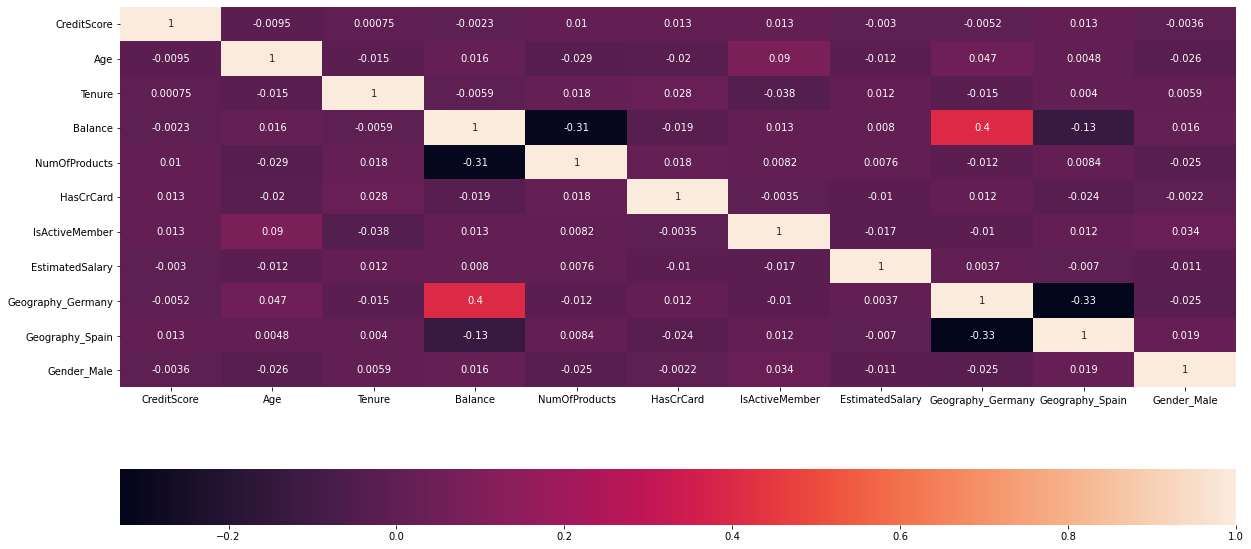

In [17]:
plt.figure(figsize=(20, 10))
sns.heatmap(features_train.corr(), annot=True, fmt='.2g', cmap=None, linewidths=0, linecolor='white',
            cbar_kws= {'orientation': 'horizontal'}, cbar = True)

Коэффициенты корреляции Пирсона в столбцe/строке Tenure низкие.\
Это значит, что нет явной линейной завивисимости кол-ва недвиджимости от других признаков.

Тогда поэкспериментируем - поробуем три варинта заполнения и посчитаем, как каждый из них отражается на **f1** моделей с дефолтными показателями (на валидационной выборке).
Заполним пропуски в столбце Tenure:
- 0 (если не указано кол-во объектов недвижимости, значит недвижимости и нет)
- медианой
- значением типа "выброс", сильно отличным от остальных значений признака (например, 50)

Создадим дубли наших фичей.\
Заполним пропуски разными способами.\
Посмотрим, как это влияет на f1 случайного леса.

In [18]:
features_train_0 = features_train
features_valid_0 = features_valid
features_train_med = features_train
features_valid_med = features_valid
features_train_50 = features_train
features_valid_50 = features_valid

In [19]:
features_train_0['Tenure'] = features_train_0['Tenure'].fillna(0)
features_valid_0['Tenure'] = features_valid_0['Tenure'].fillna(0)
features_train_med['Tenure'] = features_train_med['Tenure'].fillna(features_train_med['Tenure'].median())
features_valid_med['Tenure'] = features_valid_med['Tenure'].fillna(features_valid_med['Tenure'].median())
features_train_50['Tenure'] = features_train_50['Tenure'].fillna(50)
features_valid_50['Tenure'] = features_valid_50['Tenure'].fillna(50)

In [20]:
model = RandomForestClassifier()

data_train = [features_train_0, features_train_med, features_train_50]
data_valid = [features_valid_0, features_valid_med, features_valid_50]

print('f1 при заполнении пропусков в Tenure: 0, медианой, 50')

for i in range(len(data_train)):
    model.fit(data_train[i], target_train)
    predicted = model.predict(data_valid[i])
    score = f1_score(target_valid, predicted)
    display(score.round(5))

f1 при заполнении пропусков в Tenure: 0, медианой, 50


0.62028

0.61044

0.62083

Посмотрим, как это влияет на f1 логистической регрессии.

In [21]:
model = LogisticRegression(solver = 'liblinear')

data_train = [features_train_0, features_train_med, features_train_50]
data_valid = [features_valid_0, features_valid_med, features_valid_50]

print('f1 при заполнении пропусков в Tenure 0, медианой, 50')

for i in range(len(data_train)):
    model.fit(data_train[i], target_train)
    predicted = model.predict(data_valid[i])
    score = f1_score(target_valid, predicted)
    display(score.round(5))

f1 при заполнении пропусков в Tenure 0, медианой, 50


0.31336

0.31336

0.31336

Значения f1 у моделей регрессии равны. Видимо, это значит, что признак Tenure классифицировался моделью как не очень важный.\
У леса качество при разных вариантах различается несильно (более того, меняется, при повторном пересчете).\
Для леса способ заполнения этого признака, видимо, тоже не является существенным.\
Заполним 0 - предполагая, что если поле не заполнили, значит недвижимости нет.

In [22]:
features_train['Tenure'] = features_train['Tenure'].fillna(0)
features_valid['Tenure'] = features_valid['Tenure'].fillna(0)

#### Итог по разделу

Мы:
- избавились от бесполезных для анализа признаков
- перекодировали прямым кодированием столбцы Geography и Gender
- заполнили пропуски в столбце Tenurу медианой, так как сочли, что это даст лучший скор моделей
- масштабировали признаки

In [23]:
features_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 5132 to 8700
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        1500 non-null   float64
 1   Age                1500 non-null   float64
 2   Tenure             1500 non-null   float64
 3   Balance            1500 non-null   float64
 4   NumOfProducts      1500 non-null   float64
 5   HasCrCard          1500 non-null   int64  
 6   IsActiveMember     1500 non-null   int64  
 7   EstimatedSalary    1500 non-null   float64
 8   Geography_Germany  1500 non-null   uint8  
 9   Geography_Spain    1500 non-null   uint8  
 10  Gender_Male        1500 non-null   uint8  
dtypes: float64(6), int64(2), uint8(3)
memory usage: 109.9 KB


### 3. Исследование баланса классов и первое обучение модели (без учета дисбаланса)

Посмотрим, какой баланс классов у нас в обучающей выборке.

In [24]:
agg = target_train.value_counts(normalize = True)
agg

0    0.796286
1    0.203714
Name: Exited, dtype: float64

Text(0.5, 1.0, 'Распределение классов')

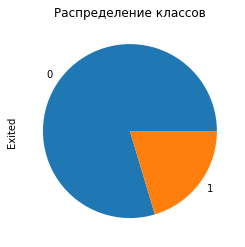

In [25]:
agg.plot(kind = 'pie')
plt.title('Распределение классов')

Что ж, дисбаланс имеет место быть. Учтем это далее.

Итак, мы решаем задачу бинарной классификации (1 - клиент уйдет, 0 - нет).\
Будем ее решать с помощью моделей случайного леса и логистической регрессии.\
Учитывая дисбаланс, сразу забудем об accuracy и в качестве скора используем f1 (как обобщающую между recall и precision).\
Дополнительно будем измерять AUC-ROC, сравнивая её значение с F1-мерой.

Обучим модели с разными гиперпараметрами и выберем модели с лучшим скором.

**Случайный лес**

Обучим модель случайного леса и посчитаем скор на валидационной выборке.

In [26]:
#Гридсерч потребовал много времени и ресурсов.
#%%time
#parametrs = { 'n_estimators': range (2, 101, 10),
#              'max_depth': range (2, 11, 1),
#              'min_samples_leaf': range (5, 51, 5) }
#model_1 = RandomForestClassifier(random_state = 123)
#grid = GridSearchCV(model_1, parametrs, scoring = 'f1' and 'roc_auc')
#grid.fit(features_train, target_train)
#grid.best_params_

In [27]:
#Сделаем цикл ручками
max_depth = 2
n_estimators = 2
min_samples_leaf = 5
valid_f1 = 0
valid_roc_auc = 0
random_forest_model = None

for i in range(2, 11):
    for j in range(2, 101, 10):
        for k in range(5, 51, 5):
            model = RandomForestClassifier(max_depth = i, n_estimators = j, min_samples_leaf = k, random_state = 123)
            model.fit(features_train, target_train)
            predicted = model.predict(features_valid)
            score_1 = f1_score(target_valid, predicted)
            probabilities_valid = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            score_2 = roc_auc_score(target_valid, probabilities_one_valid)
            if score_1 + score_2 > valid_f1 + valid_roc_auc:
                max_depth = i
                n_estimators = j
                mean_samples_leaf = k
                valid_f1 = score_1
                valid_roc_auc = score_2
                random_forest_model = model   

In [28]:
print('Гиперпараметры и accuracy для случайного леса самого высокого качества:', '\nmax_depth = ', max_depth,
     '\nn_estimators = ', n_estimators, '\nmin_samples_leaf = ', min_samples_leaf)

Гиперпараметры и accuracy для случайного леса самого высокого качества: 
max_depth =  10 
n_estimators =  42 
min_samples_leaf =  5


In [29]:
metrics_forest = pd.DataFrame([[valid_f1.round(3), valid_roc_auc.round(3)]], columns = ['f1','Roc-auc',], index = ['Лес'])
metrics_forest

,f1,Roc-auc
Лес,0.624,0.878


**Логистическая регрессия**

Проверим, какая корреляция между признаками, влияющими на целевой.\
Так мы сможем исключить лишние признаки и сделать модель более прыткой.

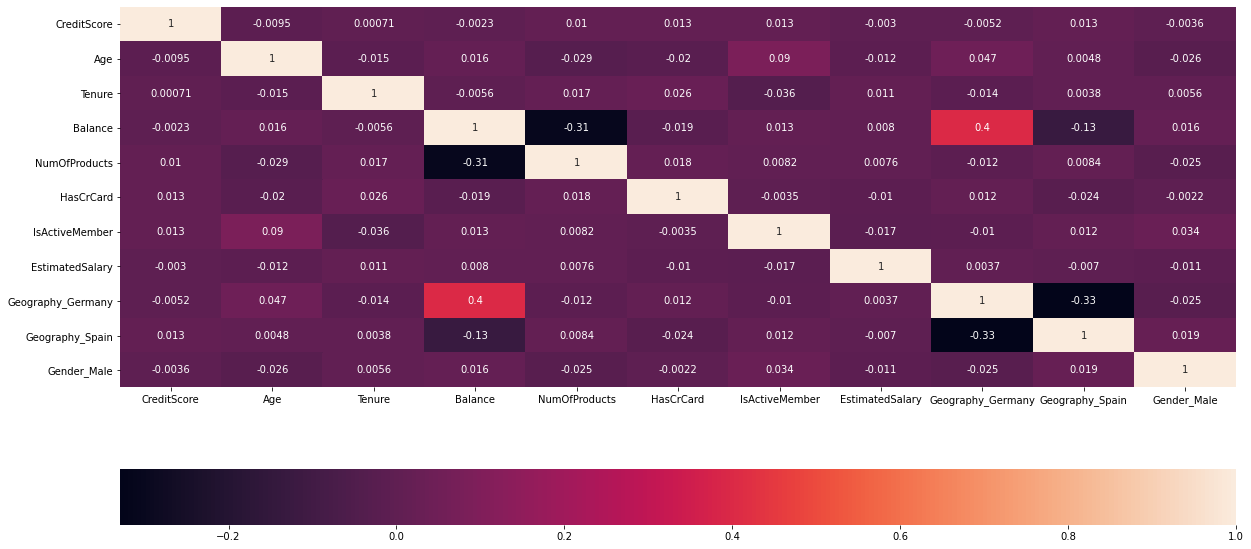

In [30]:
plt.figure(figsize=(20, 10))
sns.heatmap(features_train.corr(), annot=True, fmt='.2g', cmap=None, linewidths=0, linecolor='white',
            cbar_kws= {'orientation': 'horizontal'}, cbar = True)

Особых линейных зависимостей между признаками не видно, значит, не будем ничего исключать.
Обучим модель логистической регрессии, и посчитаем скор на валидационной выборке.

In [31]:
model = LogisticRegression(solver = 'liblinear', random_state = 123)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
f1 = f1_score(target_valid, predicted)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

In [32]:
metrics_reg = pd.DataFrame([[f1.round(3), roc_auc.round(3)]], columns = ['f1','Roc-auc',], index = ['Регрессия'])
metrics_reg

,f1,Roc-auc
Регрессия,0.313,0.769


#### Итог по разделу

Мы экспериментально обучили модели случайного леса и логистической регрессии.\
Не корректируя дисбаланс классов, корректируя только гиперпараметры в лесе, удалось добиться метрики f1:
- 0.624 для случайного леса (roc-auc = 0.878)
- 0.313 для логистической регрессии (roc-auc = 0.769)

Также мы получили первую прикидку оптимальных гиперпараметров для леса:
- max_depth = 10
- n_estimators = 42
- mean_samples_leaf = 5

Будем их использовать при исследовании в дальнейшем.

### 4. Улучшение качества модели (с учетом дисбаланса классов). Выбор лучшей модели

Мы помним, что у нас довольно сильный дисбаланс классов (80% нулей и 20% единиц).\
Чтобы  повысить качество моделей, от дисбаланса нужно избавиться.\
Это можно делать разными способами.

Используем 3 разные техники избавления от дисбаланса:
- взвешивание
- upsampling
- downsampling

И посмотрим, как каждая влияет на score.

**Взвешивание**

Сначала посмотрим, изменится ли f1 в лесе, если сбалансировать классы.\
Параллельно будем оценивать roc-auc.\
Возьмем подобранные в предыдущем разделе гиперпараметры.

In [33]:
model = RandomForestClassifier(random_state = 123, class_weight = 'balanced',
                               max_depth = 10, n_estimators = 42, min_samples_leaf = 5)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
f1 = f1_score(target_valid, predicted)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

In [34]:
metrics_forest = metrics_forest.append(pd.DataFrame([[f1.round(3), roc_auc.round(3)]], 
                                      columns = ['f1','Roc-auc',],
                                      index = ['Взвешивание_лес']))
metrics_forest

,f1,Roc-auc
Лес,0.624,0.878
Взвешивание_лес,0.636,0.876


Теперь посмотрим, что произойдет в регрессии.

In [35]:
model = LogisticRegression(solver = 'liblinear', random_state = 123, class_weight = 'balanced')
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
f1 = f1_score(target_valid, predicted)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

In [36]:
metrics_reg = metrics_reg.append(pd.DataFrame([[f1.round(3), roc_auc.round(3)]], 
                                      columns = ['f1','Roc-auc',],
                                      index = ['Взвешивание_регрессия']))
metrics_reg

,f1,Roc-auc
Регрессия,0.313,0.769
Взвешивание_регрессия,0.485,0.771


f1 вырос в обеих моделях, но в регрессии более значительно.\
Возможно, регрессия более щепетильно относится к дисбалансу.\
Roc-auc изменился незначительно.

**Upsampling**

Уменьшим количество объектов меньшего класса.

In [37]:
#Напишем функцию для увеличения количества объектов меньшего класса
def upsampling(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 123)
    
    return features_upsampled, target_upsampled

In [38]:
#Помним, что единиц в 4 раза меньше, чем 0, значит, repeat = 4
features_upsampled, target_upsampled = upsampling(features_train, target_train, 4)

In [39]:
#Напишем функцию для расчета скор-метрик
def training_score(features, target, features_result, target_result):
    model.fit(features, target)
    predicted = model.predict(features_result)
    probabilities = model.predict_proba(features_result)
    probabilities_one = probabilities[:, 1]
    roc_auc = roc_auc_score(target_result, probabilities_one)
    f1 = f1_score(target_result, predicted)
    return f1, roc_auc

Обучим лес и посмотрим, как процедура upsampling повлияла на f1 и roc-auc.

In [40]:
model = RandomForestClassifier(random_state = 123, max_depth = 10, n_estimators = 42, min_samples_leaf = 5)
f1, roc_auc = training_score(features_upsampled, target_upsampled, features_valid, target_valid)

In [41]:
metrics_forest = metrics_forest.append(pd.DataFrame([[f1.round(3), roc_auc.round(3)]], 
                                      columns = ['f1','Roc-auc',],
                                      index = ['Upsampling_лес']))
metrics_forest

,f1,Roc-auc
Лес,0.624,0.878
Взвешивание_лес,0.636,0.876
Upsampling_лес,0.620,0.874


Обучим регрессию и посмотрим, как процедура upsampling повляла на f1 и roc-auc.

In [42]:
model = LogisticRegression(solver = 'liblinear', random_state = 123)
f1, roc_auc = training_score(features_upsampled, target_upsampled, features_valid, target_valid)

In [43]:
metrics_reg = metrics_reg.append(pd.DataFrame([[f1.round(3), roc_auc.round(3)]], 
                                      columns = ['f1','Roc-auc',],
                                      index = ['Upsampling_регрессия']))
metrics_reg

,f1,Roc-auc
Регрессия,0.313,0.769
Взвешивание_регрессия,0.485,0.771
Upsampling_регрессия,0.484,0.771


**Downsampling**

Уменьшим количество объектов большего класса.

In [44]:
#Напишем функцию для уменьшения объектов большего класса.
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac = fraction, random_state = 123)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac = fraction, random_state = 123)] + [target_ones])
    return features_downsampled, target_downsampled

In [45]:
#Помним, что единиц в четыре раза меньше, чем 0, значит количество нулей нужно уменьшить в 4 раза (или умножить на 0,25)
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

Обучим лес и посмотрим на скор.

In [46]:
model = RandomForestClassifier(random_state = 123, max_depth = 10, n_estimators = 42, min_samples_leaf = 5)
f1, roc_auc = training_score(features_downsampled, target_downsampled, features_valid, target_valid)

In [47]:
metrics_forest = metrics_forest.append(pd.DataFrame([[f1.round(3), roc_auc.round(3)]], 
                                      columns = ['f1','Roc-auc',],
                                      index = ['Downsampling_лес']))
metrics_forest

,f1,Roc-auc
Лес,0.624,0.878
Взвешивание_лес,0.636,0.876
Upsampling_лес,0.620,0.874
Downsampling_лес,0.589,0.871


Обучим регрессию и посмотрим на скор.

In [48]:
model = LogisticRegression(solver = 'liblinear', random_state = 123)
f1, roc_auc = training_score(features_downsampled, target_downsampled, features_valid, target_valid)

In [49]:
metrics_reg = metrics_reg.append(pd.DataFrame([[f1.round(3), roc_auc.round(3)]], 
                                      columns = ['f1','Roc-auc',],
                                      index = ['Downsampling_регрессия']))
metrics_reg

,f1,Roc-auc
Регрессия,0.313,0.769
Взвешивание_регрессия,0.485,0.771
Upsampling_регрессия,0.484,0.771
Downsampling_регрессия,0.491,0.771


#### Итог по разделу

Мы избавились от дисбаланса классов тремя способами.\
Самый большой прирост f1 дало взвешивание на лесе.\
Roc-auc почти не меняется.\
Выберем как итоговую модель случайного леса со взвешиванием.

### 5. Финальное тестирование

Достанем из запасника предусмотрительно отложенную нами тестовую выборку, и проверим, как модель с ней справится.\
Не забудем обработать тестовую выборку также, как обучающую и валидационную.

In [50]:
#Так как мы масштабировали признаки в обучающей и валидационной выборках, то же самое нужно сделать с тестом
#Благо, у нас уже есть обученный scaler
features_test[numeric] = scaler.transform(features_test[numeric])

Проверим, нет ли в тесте пропусков в столбце Tenure.
Заполним их нулями, как для обучающей и валидационной выборок.

In [51]:
features_test['Tenure'].isnull().sum()

119

In [52]:
features_test['Tenure'] = features_test['Tenure'].fillna(0)

Гиперпараметры подберем заново, с учетом дисбаланса классов.

In [53]:
max_depth = 2
n_estimators = 2
min_samples_leaf = 5
valid_f1 = 0
valid_roc_auc = 0
random_forest_model = None

for i in range(2, 11):
    for j in range(2, 101, 10):
        for k in range(5, 51, 5):
            model = RandomForestClassifier(max_depth = i, n_estimators = j, min_samples_leaf = k, random_state = 123,
                                           class_weight = 'balanced')
            model.fit(features_train, target_train)
            predicted = model.predict(features_valid)
            score_1 = f1_score(target_valid, predicted)
            probabilities_valid  = model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            score_2 = roc_auc_score(target_valid, probabilities_one_valid)
            if score_1 + score_2 > valid_f1 + valid_roc_auc:
                max_depth = i
                n_estimators = j
                mean_samples_leaf = k
                valid_f1 = score_1
                valid_roc_auc = score_2
                random_forest_model = model   

In [54]:
print('Гиперпараметры и accuracy для случайного леса самого высокого качества с учетом дисбаланса классов:',
      '\nmax_depth = ', max_depth, '\nn_estimators = ', n_estimators, '\nmin_samples_leaf = ',
      min_samples_leaf)

Гиперпараметры и accuracy для случайного леса самого высокого качества с учетом дисбаланса классов: 
max_depth =  10 
n_estimators =  72 
min_samples_leaf =  5


Обучим итоговую модель на основе обучающей и валидационной выборок (+15% данных валидационной нельзя просто выбросить).
И оценим качество с помощью f1-меры и roc-auc.

In [55]:
features_final = pd.concat([features_train] + [features_valid])
target_final = pd.concat([target_train] + [target_valid])

model = RandomForestClassifier(max_depth = 10, n_estimators = 72, min_samples_leaf = 5, random_state = 123,
                                           class_weight = 'balanced')
f1, roc_auc = training_score(features_final, target_final, features_test, target_test)
print('Случайный лес на тестовой выборке с учетом дисбаланса методом взвешивания:', '\nf1 = ', f1.round(3),
      '\nroc_auc =', roc_auc.round(3))

Случайный лес на тестовой выборке с учетом дисбаланса методом взвешивания: 
f1 =  0.629 
roc_auc = 0.861


Ради любопытства посмотрим, как выглядядят в итоге PR- и ROC-кривые.

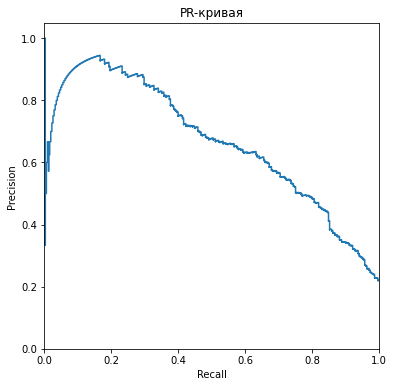

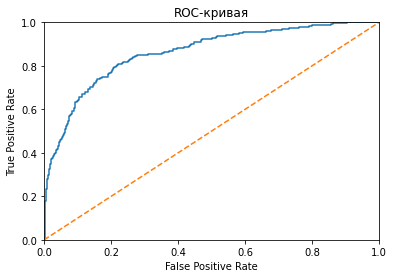

In [56]:
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
precision, recall, threshold = precision_recall_curve(target_test, probabilities_one)
plt.figure(figsize = (6,6))
plt.step(recall, precision, where = 'post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.00])
plt.title('PR-кривая')
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Мы видим, что наша ROC-кривая гораздо выше, чем прямая полностью случайной модели.\
И это прекрасно. Значит, наша модель гораздо лучше случайной.\
Кривая PR достаточно высокая, значит, качество модели хорошее.

#### Итог по разделу

Мы переподобрали гиперпараметры с учетом дисбаланса классов, обучили модель на основе обучающей и валидационной выборок.\
И получили качество 0.629 на тестовой выборке (f1-мера).\
Значение Roc-auc в итоге получили 0,861.

### 6. Общий вывод

Мы обучили модель дерево решений (отдав ей преимущество перед логистической регрессией).\
Оптимальные гиперпараметры для этого леса:
- max_depth = 10
- n_estimators = 72
- mean_samples_leaf = 5
                
Избавились от дисбаланса классов. Получили высокое качество модели (f1-мера + roc-auc).\
Рекомендуем данную модель банку "X" для прогноза - уйдет клиент в ближайшее время из банка или нет.